# Data loader example

This is example code that demonstrates use of our custom data loader for the POCOVID-Net training data. Much of this code is based on snippets from the the official PyTorch tutorial on [custom datasets, dataloaders, and transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). 

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms as tv_tsfm
import matplotlib.pyplot as plt

For the purposes of this example, I am assuming this notebook is being run from the `code/app` directory in this repository. 

⚠️ If you use a different working directory, you will need to adjust the `root_dir` argument to the `PocovidDataset` constructor accordingly. 

Below, I print the current working directory:

In [2]:
os.getcwd() # show current working directory (for reference, not required for code below to work)

'/home/nathan/Code/covid19_pocus_ultrasound_pytorch/code/app'

We must append to our Python path in order to be able to include the `pocovid_dataset` module, which lives in `../util`:

In [3]:
import sys
sys.path.append('../util')
from pocovid_dataset import PocovidDataset

## Create an instance of `PocovidDataset`, applying transformations "in place"
Here, like in the paper, we resize to 224x224, then rotate randomly by at most 10 degrees, and translate randomly by at most 10% the width/height of the image.

In [4]:
transformed_dataset = PocovidDataset(root_dir='../data/pocus_images',
                                     transform=tv_tsfm.Compose([
                                       tv_tsfm.Resize((224,224)),
                                       tv_tsfm.RandomAffine(10,translate=(0.1,0.1)),
                                       tv_tsfm.ToTensor()
                                       ]))

## Iterating through the dataset

### Option A: Using a `for` loop
First, let's iterate using a simple `for` loop. This works, but may not be as powerful / as efficient as using a `DataLoader` (see Option B).

In [5]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['class'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


### Option B: Using `torch.utils.data.DataLoader`

In [6]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

In [7]:
covid_idx = transformed_dataset.get_covid_class_idx();
pneu_idx = transformed_dataset.get_pneu_class_idx();
regular_idx = transformed_dataset.get_regular_class_idx();
lbl_map = {covid_idx:"COVID",pneu_idx:"Pneumonia",regular_idx:"Regular"} 

# based on show_landmarks_batch() in the official PyTorch dataloader tutorial
def show_labeled_images_batch(sample_batched):
  """Show image with class labels for a batch of samples."""
  images_batch, classes_batch = sample_batched['image'], sample_batched['class']
  batch_size = len(images_batch)
  assert images_batch.size(2) == images_batch.size(3)   # assume images are square
  im_width = images_batch.size(2) 
  grid_border_size = 2

  labels = [lbl_map[i.item()] for i in classes_batch]
  title_str = 'From left: ' + ', '.join(labels)
  plt.title(title_str)
  
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.title(title_str)

ℹ️ Note that becuase I passed `shuffle=True` to the constructor of `DataLoader`, we get a different result each time we run the FOR loop below.

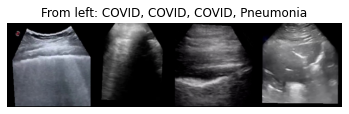

In [8]:
for i_batch, sample_batched in enumerate(dataloader):
    # observe 4th batch, visualize images, and stop
    if i_batch == 3:
        plt.figure()
        
        show_labeled_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break